In [3]:
import random
import math
import copy
from heapq import heappush, heappop
from collections import defaultdict
def isSorted(nodes):
    if(len(nodes)==0):
        return True
    for i in range(1,len(nodes)):
        if(nodes[i-1] > nodes[i]):
            return False
    return True

def EuclideanDistance(point1_x, point1_y, point2_x, point2_y):
    internalCalculation = math.pow((point1_x - point2_x),2) + math.pow((point1_y - point2_y),2)
    return math.sqrt(internalCalculation);

def getDistanceBetweenNodes(node, otherNode, AdjHash, Map, DistanceComputation):
    if(node == otherNode):
        return 0;
    if(otherNode in AdjHash and node in AdjHash[otherNode]):
        return AdjHash[otherNode][node]
    return DistanceComputation(Map[node][0], Map[node][1], Map[otherNode][0], Map[otherNode][1])

def computeAdjHashOfCompleteGraph(Map, DistanceComputation):
    # Input::  Map: {0: (0.13037375991631983, 0.17982980099790336), ... }
    nodes = Map.keys()
    assert isSorted(nodes)
    AdjHash= {}
    for node in nodes:
        AdjHash[node] = {}
        for otherNode in nodes:
            AdjHash[node][otherNode] = getDistanceBetweenNodes(node, otherNode, AdjHash, Map, DistanceComputation)
    return AdjHash

def TspGenerator(numberOfCities, lowRange=0.0, highRange=1.0, DistanceComputation=EuclideanDistance):
    Map = {}
    inverseMap = {}
    AdjHash = {}
    for x in range(0, numberOfCities):
        coordinate = (random.uniform(lowRange, highRange), random.uniform(lowRange, highRange))
        tries = 0;
        while(coordinate in inverseMap):
            coordinate = (random.uniform(lowRange, highRange), random.uniform(lowRange, highRange))
            tries+=1;
            if(tries==5):
                print "Unable to Generate Coordinates"
                return ;
        Map[x] = coordinate
        inverseMap[coordinate] = x
    return Map, inverseMap, computeAdjHashOfCompleteGraph(Map, DistanceComputation);

In [2]:
def isAllVisited(VisitedHash, nodes):
    for node in nodes:
        if(node not in VisitedHash):
            return False
    return True

def PrimsAlgorithm(startNode, nodes, AdjHash):
#     print startNode, nodes
    #Input startNode : type int, nodes : type list of int's
    MSTCost = 0;
    h = []
    visitedHash = {}
    visitedHash[startNode] = True
    prevNode = startNode
    MstEdges = []
    while(not isAllVisited(visitedHash, nodes)):
        for node in nodes:
            if(node not in visitedHash.keys()):
#                 print h
                heappush(h, (AdjHash[prevNode][node], (prevNode, node)))
        cost, edge = heappop(h)
        parentNode, minNode = edge
        while(minNode in visitedHash):
            # if min node was alreadyVisited
            cost, edge = heappop(h)
            parentNode, minNode = edge
        MSTCost += cost
        MstEdges.append((parentNode, minNode))
        visitedHash[minNode] = True
    return MSTCost, MstEdges;

def MSTHeuristic(startNode, nodes, AdjHash):
    #Input :: AdjHash is a Adjacency map of the entire set of nodes with the value being the distance
    assert startNode in nodes;
    cost, edges = PrimsAlgorithm(startNode, nodes, AdjHash)
    return cost;
    

    
class TspNode:
    def __init__(self, x, y, nodeNumber, path_cost, parentNode, heuristicCostMap, listOfNodeNumbers, AdjHash, HeuristicFunction=MSTHeuristic):
        self.pos_x = x
        self.pos_y = y
        self.node_number = nodeNumber
        self.g_cost = path_cost
        self.parent = parentNode
        
        # This is not the start node
        if(parentNode!=-1):
            self.nodes_visited = copy.copy(parentNode.nodes_visited)
            MSTSet = frozenset(set(listOfNodeNumbers) - set(self.nodes_visited.keys()))
            if(len(MSTSet)==1):
                heuristicCostMap[MSTSet] = 0;
            if(MSTSet not in heuristicCostMap):
                heuristicCostMap[MSTSet] = HeuristicFunction(self.node_number, list(MSTSet), AdjHash)
            heuristicCost = heuristicCostMap[MSTSet]
        else:
            heuristicCostMap[frozenset(listOfNodeNumbers)] = HeuristicFunction(self.node_number, listOfNodeNumbers, AdjHash)
            heuristicCost = heuristicCostMap[frozenset(listOfNodeNumbers)]
        self.h_cost = heuristicCost
        self.f_cost = self.g_cost + self.h_cost
        
def goalTest(node, listOfNodeNumbers):
    return isAllVisited(node.nodes_visited, list(set(listOfNodeNumbers) - set([node.node_number])))

def appendToFrontier(newNode, Frontier):
    if(newNode.f_cost in Frontier):
        Frontier[newNode.f_cost].append(newNode)
    else:
        Frontier[newNode.f_cost] = [newNode]

def printPathTraversed(node, printOutput=True):
    pathTraversed = []
    while(node.parent!=-1):
        pathTraversed.append(node.node_number)
        node=node.parent
    pathTraversed.append(node.node_number)
    pathTraversed = list(reversed(pathTraversed))
    pathTraversed.append(pathTraversed[0])
    if(printOutput):
        print pathTraversed
    return pathTraversed
    
def popMinNode(Frontier):
    isFrontierPresent = bool([a for a in Frontier.values() if a != []])
    if not isFrontierPresent:
        return None 
    m = min(i for i in Frontier.keys() if len(Frontier[i]) > 0)
    minNode = Frontier[m].pop(0)
    return minNode;
        
def hasTraversedPreviously(newNodeNumber, node):
    if(newNodeNumber in node.nodes_visited):
        return True
    return False

def findBestNode(Frontier):
    bestNode = popMinNode(Frontier)
    if bestNode == None:
        return None 
    while((hasTraversedPreviously(bestNode.node_number, bestNode))):
        bestNode = popMinNode(Frontier)
    return bestNode
        
def checkIfFCostIsGreaterThanBestFinalNode(bestFinalNode, node):
    if(bestFinalNode.f_cost <= node.f_cost):
        return False
    return True

def checkNoOtherBetterNodeToExpand(Frontier, finalNode):
    bestNodeToExpand = findBestNode(Frontier)
    return checkIfFCostIsGreaterThanBestFinalNode(finalNode, bestNodeToExpand)

def appendToFrontier(newNode, Frontier):
    if(newNode.f_cost in Frontier):
        Frontier[newNode.f_cost].append(newNode)
    else:
        Frontier[newNode.f_cost] = [newNode]

def expandNode(Node, Frontier, AdjHash, listOfNodeNumbers, Map, heuristicCostMap, HeuristicFunction):
    Node.nodes_visited[Node.node_number] = True
#     print Frontier
    toExpand = list(set(listOfNodeNumbers) - set(Node.nodes_visited.keys()))
    cntNodesGen = 0
    for nodeNumber in toExpand:
        if(nodeNumber != Node.node_number):
            latitude = Map[nodeNumber][0]
            longitude = Map[nodeNumber][1]
            tspNode = TspNode(latitude, longitude, nodeNumber, Node.g_cost+AdjHash[Node.node_number][nodeNumber], Node, heuristicCostMap, listOfNodeNumbers, AdjHash, HeuristicFunction)
            appendToFrontier(tspNode, Frontier)
            cntNodesGen+=1
#     print Frontier
    return cntNodesGen;
    
def solveAstar(startNode, AdjHash, listOfNodeNumbers, Map, HeuristicFunction=MSTHeuristic, printOutput=True):
    heuristicCostMap = {}
    #Input startNode : type int, listOfNodeNumbers : type list of int's
    latitude = Map[startNode][0]
    longitude = Map[startNode][1]
    sNode = TspNode(latitude, longitude, startNode, 0, -1, heuristicCostMap, listOfNodeNumbers, AdjHash, HeuristicFunction)
    sNode.nodes_visited = {}
    Frontier = defaultdict(list)
    Frontier[sNode.f_cost] = [sNode]
#     print Frontier
    isCompleted = False
    bestFinalNode = None
    FoundCostToFinal = False;
    noOfNodesExpanded = 0
    cntNodesGenerated = 0
    while(len(Frontier)!=0 or isCompleted):
        bestNode = findBestNode(Frontier)
        if(bestNode==None):
            break;
        isNodeGoalState = goalTest(bestNode, listOfNodeNumbers)
#         if(isNodeGoalState and checkNoOtherBetterNodeToExpand(Frontier, bestNode)):
#             isCompleted = True
#             break
        if(bestFinalNode != None and bestNode.f_cost > bestFinalNode.g_cost + AdjHash[bestFinalNode.node_number][sNode.node_number]):
            isCompleted = True
            break
        if(isNodeGoalState):
            if(printOutput):
                print " ******* reached Goal State ******* "
                print " Nodes Reached by Goal State of node number %d is %s" %(bestNode.node_number, bestNode.nodes_visited)
                print " ******* ****************** ******* "
            
#             if(bestFinalNode != None):
                #print bestFinalNode.f_cost
                #print bestFinalNode.g_cost + AdjHash[bestFinalNode.node_number][sNode.node_number]
            if(not FoundCostToFinal):
                bestFinalNode = bestNode
                FoundCostToFinal = True
            else:
                if(bestFinalNode.g_cost + AdjHash[bestFinalNode.node_number][sNode.node_number] > bestNode.g_cost  + AdjHash[bestNode.node_number][sNode.node_number]):
                    bestFinalNode=bestNode
        if(not isNodeGoalState):
            noOfNodesExpanded+=1
            if(printOutput):
                print "Expanding Node : %d and nodes visited %s" %(bestNode.node_number, bestNode.nodes_visited)
            cntNodesGenerated += expandNode(bestNode, Frontier, AdjHash, listOfNodeNumbers, Map, heuristicCostMap, HeuristicFunction)
    if(printOutput):
        print heuristicCostMap
    totalCost = bestFinalNode.g_cost + AdjHash[bestFinalNode.node_number][sNode.node_number]
    return bestFinalNode, totalCost, noOfNodesExpanded, cntNodesGenerated

In [4]:
Map, inverseMap, AdjHash = TspGenerator(10)
nodes = Map.keys()
startNode = 0
print Map
print AdjHash
bestFinalNode, TotalCost, noOfNodesExpanded, noOfNodesGenerated = solveAstar(startNode, AdjHash, nodes, Map)

{0: (0.2033827297058306, 0.9562512143565314), 1: (0.9487836498883154, 0.7314584654230407), 2: (0.43897047333718353, 0.9927528394062425), 3: (0.840187307459104, 0.3418782347437366), 4: (0.42687910972110943, 0.869284223921773), 5: (0.4936600257565136, 0.5660062795064156), 6: (0.6933004928108846, 0.9602071650912056), 7: (0.724321301177792, 0.02301351038396382), 8: (0.19029763720915926, 0.15605589885605453), 9: (0.7648942365340122, 0.48521745806438277)}
{0: {0: 0, 1: 0.7785591254246337, 2: 0.23839872814380064, 3: 0.8848583097455933, 4: 0.23982053562031191, 5: 0.4863661355179521, 6: 0.48993373444995086, 7: 1.0687888506918648, 8: 0.8003022945078655, 9: 0.7329174386430891}, 1: {0: 0.7785591254246337, 1: 0, 2: 0.5728736552333585, 3: 0.4044328395730772, 4: 0.5397965253249539, 5: 0.4842643276842257, 6: 0.34292508095811175, 7: 0.7431538200863697, 8: 0.9520447179842972, 9: 0.30732710594543466}, 2: {0: 0.23839872814380064, 1: 0.5728736552333585, 2: 0, 3: 0.7645996985203368, 4: 0.12405926037079178, 

In [5]:
printPathTraversed(bestFinalNode)
print TotalCost,noOfNodesExpanded

[0, 2, 4, 6, 1, 9, 3, 7, 8, 5, 0]
3.34209479211 23


In [5]:
import timeit
import datetime
import random
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

startRange = 3
endRange = 15
nodes_size = []
time_taken = []
nodes_expanded = []
nodes_generated = []

# Data Used 
MapsUsed = []
inverseMapsUsed = []
AdjHashUsed = []
TotalCosts = []
PathsTraversed = []
for i in range(0,100):
    noOfNodes = random.randint(startRange, endRange)
    Map, inverseMap, AdjHash = TspGenerator(noOfNodes)
    nodes = Map.keys()
    nodes_size.append(noOfNodes)
    startNode = 0
#     print "###### STARTED #######"
#     print Map
    start_time = timeit.default_timer()
    bestFinalNode, TotalCost, noOfNodesExpanded, noOfNodesGenerated = solveAstar(startNode, AdjHash, nodes, Map, MSTHeuristic, False)
    elapsed = timeit.default_timer() - start_time
    nodes_generated.append(noOfNodesGenerated)
    nodes_expanded.append(noOfNodesExpanded)
    time_taken.append(elapsed)
    MapsUsed.append(Map)
    inverseMapsUsed.append(inverseMap)
    AdjHashUsed.append(AdjHash)
    TotalCosts.append(TotalCost)
    PathsTraversed.append(printPathTraversed(bestFinalNode, False))



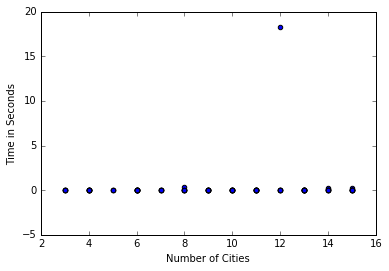

In [6]:
# plot
plt.xlabel('Number of Cities')
plt.ylabel('Time in Seconds')
plt.scatter(nodes_size,time_taken)

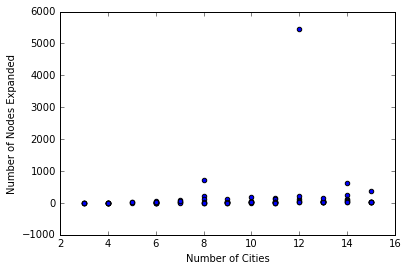

In [7]:
# plot
plt.xlabel('Number of Cities')
plt.ylabel('Number of Nodes Expanded')
plt.scatter(nodes_size,nodes_expanded)

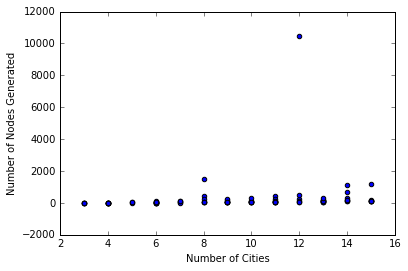

In [8]:
# plot
plt.xlabel('Number of Cities')
plt.ylabel('Number of Nodes Generated')
plt.scatter(nodes_size,nodes_generated)

In [9]:
# Testing Prims Algorithm
ExamplestartNode = 1
Examplenodes = [1,2,3,4]
ExampleAdjHash =  {
    1:{ 
        1: 0,
        2: 10,
        3: 15,
        4: 20
      },
    2:{ 
        1: 10,
        2: 0,
        3: 35,
        4: 25
      },
    3:{ 
        1: 15,
        2: 35,
        3: 0,
        4: 30
      },
    4:{ 
        1: 20,
        2: 25,
        3: 30,
        4: 0
      }
}
ExampleMap = {
    1:(0,0),
    2:(1,1),
    3:(2,2),
    4:(3,3)
}
ExampleheuristicCost, Edges = PrimsAlgorithm(ExamplestartNode, Examplenodes, ExampleAdjHash)


In [10]:
ExamplebestNode, ExampleTotalCost, ExamplenoOfNodesExpanded, ExampleNoOfNodesGenerated = solveAstar(ExamplestartNode, ExampleAdjHash, Examplenodes, ExampleMap)

Expanding Node : 1 and nodes visited {}
Expanding Node : 2 and nodes visited {1: True}
Expanding Node : 4 and nodes visited {1: True, 2: True}
 ******* reached Goal State ******* 
 Nodes Reached by Goal State of node number 3 is {1: True, 2: True, 4: True}
 ******* ****************** ******* 
Expanding Node : 3 and nodes visited {1: True}
Expanding Node : 4 and nodes visited {1: True, 3: True}
 ******* reached Goal State ******* 
 Nodes Reached by Goal State of node number 2 is {1: True, 3: True, 4: True}
 ******* ****************** ******* 
Expanding Node : 3 and nodes visited {1: True, 2: True}
Expanding Node : 2 and nodes visited {1: True, 3: True}
 ******* reached Goal State ******* 
 Nodes Reached by Goal State of node number 4 is {1: True, 2: True, 3: True}
 ******* ****************** ******* 
 ******* reached Goal State ******* 
 Nodes Reached by Goal State of node number 4 is {1: True, 2: True, 3: True}
 ******* ****************** ******* 
Expanding Node : 4 and nodes visited {

In [11]:
print printPathTraversed(ExamplebestNode)
print ExampleTotalCost

[1, 2, 4, 3, 1]
[1, 2, 4, 3, 1]
80


In [12]:
def getInputFromFile(fileName):
    try:
        Map = {}
        inverseMap = {}
        in_file = open(fileName, 'r')
        lines = in_file.readlines()
        ind = 0;
        for line in lines:
            if(line[0]=='1'):
                break
            else:
                ind+=1
        for line in lines[ind:len(lines)-1]:
            data = line.split()
            nodeNo = int(data[0])
            latitude, longitude = float(data[1]), float(data[2])
            coordinate = (latitude, longitude)
            Map[nodeNo] = coordinate
            inverseMap[coordinate] = nodeNo
    finally:
        in_file.close()
    return Map, inverseMap, computeAdjHashOfCompleteGraph(Map, DistanceComputation=EuclideanDistance)


#GEOM-norm
M_PI = 3.14159265358979323846264

def geom_edgelen(xi, xj, yi, yj):
    lati = M_PI * xi / 180.0;
    latj = M_PI * xj / 180.0;

    longi = M_PI * yi / 180.0;
    longj = M_PI * yj / 180.0;

    q1 = math.cos (latj) * math.sin(longi - longj);
    q3 = math.sin((longi - longj)/2.0);
    q4 = math.cos((longi - longj)/2.0);
    q2 = math.sin(lati + latj) * q3 * q3 - math.sin(lati - latj) * q4 * q4;
    q5 = math.cos(lati - latj) * q4 * q4 - math.cos(lati + latj) * q3 * q3;
    return (int) (6378388.0 * math.atan2(sqrt(q1*q1 + q2*q2), q5) + 1.0);



In [13]:
# Optional Question Answers : (Q6.4)
def OptimizedMSTHeuristic(startNode, nodes, AdjHash):
#     print "COMPUTING Optimized HEURISTIC"
    minCostBackToStartNode = 0.0
    for node in nodes:
        if(node!=startNode):
            minCostBackToStartNode = min(minCostBackToStartNode, AdjHash[node][startNode])
    return MSTHeuristic(startNode, nodes, AdjHash) + minCostBackToStartNode

WCityMap, WCityinverseMap, WCityAdjHash = getInputFromFile('wi29.tsp.txt')
WCitystartNode = 1
WCitynodes = WCityMap.keys()
print WCityMap

{1: (20833.3333, 17100.0), 2: (20900.0, 17066.6667), 3: (21300.0, 13016.6667), 4: (21600.0, 14150.0), 5: (21600.0, 14966.6667), 6: (21600.0, 16500.0), 7: (22183.3333, 13133.3333), 8: (22583.3333, 14300.0), 9: (22683.3333, 12716.6667), 10: (23616.6667, 15866.6667), 11: (23700.0, 15933.3333), 12: (23883.3333, 14533.3333), 13: (24166.6667, 13250.0), 14: (25149.1667, 12365.8333), 15: (26133.3333, 14500.0), 16: (26150.0, 10550.0), 17: (26283.3333, 12766.6667), 18: (26433.3333, 13433.3333), 19: (26550.0, 13850.0), 20: (26733.3333, 11683.3333), 21: (27026.1111, 13051.9444), 22: (27096.1111, 13415.8333), 23: (27153.6111, 13203.3333), 24: (27166.6667, 9833.3333), 25: (27233.3333, 10450.0), 26: (27233.3333, 11783.3333), 27: (27266.6667, 10383.3333), 28: (27433.3333, 12400.0), 29: (27462.5, 12992.2222)}


In [14]:
WCitybestNode, WCityTotalCost, WCitynoOfNodesExpanded, WCityNoOfNodesExpanded = solveAstar(WCitystartNode, WCityAdjHash, WCitynodes, WCityMap, OptimizedMSTHeuristic, False)

In [15]:
printPathTraversed(WCitybestNode)
print "Total Cost was %f" %(WCityTotalCost)

[1, 2, 6, 5, 4, 8, 7, 9, 3, 13, 12, 10, 11, 15, 19, 18, 22, 23, 21, 29, 28, 26, 20, 16, 24, 27, 25, 17, 14, 1]
Total Cost was 33842.943130


Q 6.6
Implement and test a hill-climbing method to solve TSPs. Compare the results with the optimal solutions obtained using A*


In [16]:
#http://homepage.divms.uiowa.edu/~hzhang/c231/ch12.pdf
#https://www.cs.cmu.edu/afs/cs/academic/class/15381-s07/www/slides/012507searchlocal.pdf
class HillNode:
    def __init__(self, x, y, nodeNumber, path_cost, parentNode, AdjHash):
        self.pos_x = x
        self.pos_y = y
        self.node_number = nodeNumber
        self.g_cost = path_cost
        self.parent = parentNode

def CostTour(Tour, AdjHash):
    prev = Tour[0].node_number
    Cost = 0.0
    for ind in range(1,len(Tour)):
        node = Tour[ind]
        Cost+=AdjHash[prev][node.node_number]
        prev = node.node_number
    #add Cost For Start as well
    Cost+=AdjHash[prev][0]
    return Cost
       
def printTour(Tour):
    Traversal = []
    for ind in range(0,len(Tour)):
        node = Tour[ind]
        Traversal.append(node.node_number)
    Traversal.append(Tour[0].node_number)
    print str(Traversal)
    return (Traversal)

def findNeighbour(Tour,AdjHash,pathCost):
    prev = 0
    # I pick two nodes randomly except start and swap
    index1=1
    index2=1
    newTour = copy.copy(Tour)
    Cost = 0
    changed = False
    while(index1==index2):
        index1 = random.randint(1, len(Tour)-1)
        index2 = random.randint(1, len(Tour)-1)
    swapNode = newTour[index1]
    newTour[index1] = newTour[index2]
    newTour[index2] = swapNode
    for ind in range(1,len(newTour)):
        node = Tour[ind]
        Cost+=AdjHash[prev][node.node_number]
        node.g_cost = Cost
        prev = node.node_number
    #add Cost For Start as well
    Cost+=AdjHash[prev][0]
    newTourCost = CostTour(newTour,AdjHash)
    oldTourCost = CostTour(Tour,AdjHash)
#     print "new Tour %s Traversal has a cost of %f while old Tour %s has a cost of %f" %(printTour(newTour), newTourCost, printTour(Tour), oldTourCost)
    if(newTourCost<oldTourCost):
        changed = True
        Tour = newTour
    return newTour, changed, Cost
        
    
def HillClimbing(startNodeNumber, AdjHash, listOfNodeNumbers, Map):
    Tour = []
    prevNode = -1
    prevNodeNumber = 0
    pathCost = 0.0
    MAX_ITER = 100
    iterations = 0
    for ind in range(0,len(listOfNodeNumbers)):
        nodeNumber = listOfNodeNumbers[ind]
        latitude = Map[nodeNumber][0]
        longitude = Map[nodeNumber][1]
        node = HillNode(latitude, longitude, nodeNumber, pathCost, prevNode, AdjHash)
        if(ind<len(listOfNodeNumbers)-1):
            nextNodeNumber = listOfNodeNumbers[ind+1]
        else:
            nextNodeNumber = listOfNodeNumbers[0]
        pathCost+= AdjHash[nodeNumber][nextNodeNumber];
        Tour.append(node);
        prevNode = node
    changed=True
#     print printTour(Tour);
    while(iterations < MAX_ITER):
        newTour, changed, pathCost = findNeighbour(Tour,AdjHash,pathCost)
        if(changed):
            Tour = copy.copy(newTour)
#             printTour(Tour)
        if(iterations >= MAX_ITER):
            break
        iterations+=1
#     print printTour(Tour)
#     print AdjHash
    return CostTour(Tour, AdjHash), Tour
        
        
        
    
    

In [17]:
# http://stackoverflow.com/questions/5595425/what-is-the-best-way-to-compare-floats-for-almost-equality-in-python
def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

HillClimbingTotalCosts = []
failedFindingOptimalSolutionInHillClimbing = 0
for i in range(0,100):
    Map = MapsUsed[i]
    inverseMap = inverseMapsUsed[i]
    AdjHash = AdjHashUsed[i]
    startNode = 0
    nodes = Map.keys()
    hcCost, Tour = HillClimbing(startNode, AdjHash, nodes, Map)
    HillClimbingTotalCosts.append(hcCost)
    print HillClimbingTotalCosts[i], TotalCosts[i], isclose(TotalCosts[i], HillClimbingTotalCosts[i])
    if(not isclose(TotalCosts[i], HillClimbingTotalCosts[i])):
#         if(TotalCosts[i]>HillClimbingTotalCosts[i]):
#             print AdjHash, printTour(Tour), PathsTraversed[i]
#         print TotalCosts[i], HillClimbingTotalCosts[i]
#         assert TotalCosts[i]<HillClimbingTotalCosts[i]
        failedFindingOptimalSolutionInHillClimbing+=1;
print "Hill Climbing Failed to Find Similar Solutions in %d cases out of 100" %(failedFindingOptimalSolutionInHillClimbing)


3.79085728212 3.1150689781 False
2.86432094629 2.75205540519 False
3.48078571446 3.5476047221 False
2.87149103929 2.61021146585 False
2.3916631047 2.3916631047 True
1.61260088456 1.61260088456 True
3.45113906988 3.51628921393 False
2.82050382441 2.82050382441 True
2.45436007348 2.1958206482 False
2.37273066476 2.37273066476 True
1.18423913436 1.18423913436 True
3.12689767656 2.68966493377 False
2.93236018237 3.07373945117 False
2.41032498698 2.41032498698 True
4.26413412256 3.88642125473 False
2.51333480982 2.51333480982 True
3.25097781358 3.42366399574 False
1.86692155861 1.86692155861 True
2.64588354809 2.61835775775 False
1.61663062024 1.62054709788 False
3.32375707355 3.11357528321 False
2.00430381345 2.00430381345 True
4.0923462088 3.47964278168 False
3.10227277165 3.08734023625 False
4.30748097505 3.74150418003 False
1.17837566665 1.17837566665 True
1.32888042899 1.32888042899 True
2.86241073792 2.83594424887 False
4.0437993607 2.94782921188 False
3.1128256332 2.81549347082 False

Propose an inadmissible heuristic for the TSP problem and compare the performance of A* (number of nodes expanded and solution quality) with the inadmissible heuristic versus the admissible one.


In [18]:
# An inadmissible Heurisitic could be 10 Times the Minimum Spanning Tree because it is an overestimate of the true cost to reaching the solution
def InadmissibleMSTHeuristic(startNode, nodes, AdjHash):
#     print "COMPUTING INADMISSIBLE HEURISTIC"
    return 10*MSTHeuristic(startNode, nodes, AdjHash)


bestFinalNode, TotalCost, noOfNodesExpanded, noOfNodesGenerated = solveAstar(startNode, AdjHash, nodes, Map, InadmissibleMSTHeuristic, True)
print TotalCost

Expanding Node : 0 and nodes visited {}
Expanding Node : 3 and nodes visited {0: True}
Expanding Node : 8 and nodes visited {0: True, 3: True}
Expanding Node : 6 and nodes visited {0: True, 8: True, 3: True}
Expanding Node : 4 and nodes visited {0: True, 8: True, 3: True, 6: True}
Expanding Node : 2 and nodes visited {0: True, 8: True, 3: True, 4: True, 6: True}
Expanding Node : 9 and nodes visited {0: True, 2: True, 3: True, 4: True, 6: True, 8: True}
Expanding Node : 5 and nodes visited {0: True, 2: True, 3: True, 4: True, 6: True, 8: True, 9: True}
Expanding Node : 1 and nodes visited {0: True, 2: True, 3: True, 4: True, 5: True, 6: True, 8: True, 9: True}
 ******* reached Goal State ******* 
 Nodes Reached by Goal State of node number 7 is {0: True, 1: True, 2: True, 3: True, 4: True, 5: True, 6: True, 8: True, 9: True}
 ******* ****************** ******* 
{frozenset([7]): 0, frozenset([1, 2, 3, 4, 5, 6, 7, 8, 9]): 40.08291411650744, frozenset([1, 2, 4, 5, 6, 7, 9]): 31.66239052635

In [19]:
InAdmissibleHeuristictime_taken = []
InAdmissibleHeuristicnodes_expanded = []
InAdmissibleHeuristicnodes_generated = []
InAdmissibleHeuristicTotalCosts = []

for i in range(0,100):
    Map = MapsUsed[i]
    inverseMap = inverseMapsUsed[i]
    AdjHash = AdjHashUsed[i]
#     print Map
#     print inverseMap
#     print AdjHash
    startNode = 0
#     print "###### STARTED #######"
#     print Map
    nodes = Map.keys()
    start_time = timeit.default_timer()
    bestFinalNode, TotalCost, noOfNodesExpanded, noOfNodesGenerated = solveAstar(startNode, AdjHash, nodes, Map, InadmissibleMSTHeuristic, False)
    elapsed = timeit.default_timer() - start_time
    InAdmissibleHeuristicnodes_generated.append(noOfNodesGenerated)
    InAdmissibleHeuristicnodes_expanded.append(noOfNodesExpanded)
    InAdmissibleHeuristictime_taken.append(elapsed)
    InAdmissibleHeuristicTotalCosts.append(TotalCost)


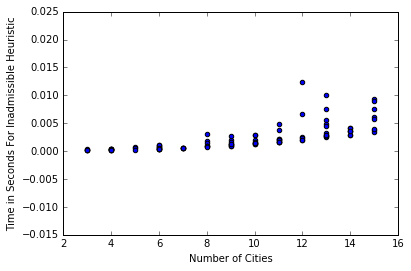

In [20]:
# plot
plt.xlabel('Number of Cities')
plt.ylabel('Time in Seconds For Inadmissible Heuristic')
plt.scatter(nodes_size,InAdmissibleHeuristictime_taken)

In [21]:

FailedToFindOptimalSolutions = 0
for i in range(0,100):
    print InAdmissibleHeuristicTotalCosts[i], TotalCosts[i], isclose(TotalCosts[i],InAdmissibleHeuristicTotalCosts[i])
    if(not isclose(TotalCosts[i],InAdmissibleHeuristicTotalCosts[i])):
#         assert TotalCosts[i] < InAdmissibleHeuristicTotalCosts[i]
        FailedToFindOptimalSolutions+=1;

print "THE INADMISSIBLE HEURISTIC WAS UNABLE TO FIND SIMILAR SOLUTION IN %d CASES OUT OF 100" %(FailedToFindOptimalSolutions)

3.1150689781 3.1150689781 True
2.86432094629 2.75205540519 False
4.06515309858 3.5476047221 False
2.61021146585 2.61021146585 True
2.3916631047 2.3916631047 True
1.61260088456 1.61260088456 True
4.0272460561 3.51628921393 False
2.82050382441 2.82050382441 True
2.1958206482 2.1958206482 True
2.37273066476 2.37273066476 True
1.18423913436 1.18423913436 True
2.68966493377 2.68966493377 True
3.44977723831 3.07373945117 False
2.49480619687 2.41032498698 False
4.62381509288 3.88642125473 False
2.79412996511 2.51333480982 False
2.70690428273 3.42366399574 False
1.92647839602 1.86692155861 False
2.61835775775 2.61835775775 True
1.70188346559 1.62054709788 False
3.11357528321 3.11357528321 True
2.01725453148 2.00430381345 False
3.66412263502 3.47964278168 False
3.12152856146 3.08734023625 False
3.74150418003 3.74150418003 True
1.21131790236 1.17837566665 False
1.32888042899 1.32888042899 True
3.13048841439 2.83594424887 False
2.94782921188 2.94782921188 True
2.86969202599 2.81549347082 False
3.

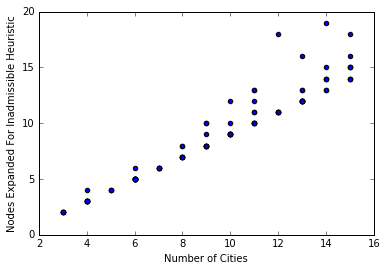

In [22]:
# plot
plt.xlabel('Number of Cities')
plt.ylabel('Nodes Expanded For Inadmissible Heuristic')
plt.scatter(nodes_size,InAdmissibleHeuristicnodes_expanded)


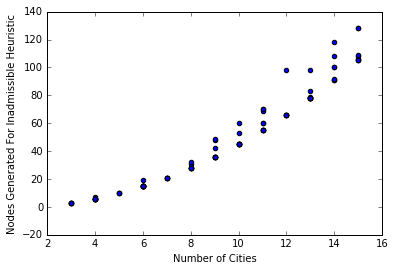

In [23]:
# plot
plt.xlabel('Number of Cities')
plt.ylabel('Nodes Generated For Inadmissible Heuristic')
plt.scatter(nodes_size,InAdmissibleHeuristicnodes_generated)
